# Q3. Sarsa

In [163]:
import gym
import matplotlib
import numpy as np
import pandas as pd
import random
import itertools
import sys
from collections import defaultdict
from collections import namedtuple
from matplotlib import pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [164]:
env = gym.make("CliffWalking-v0")
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [165]:
action = ["up", "right", "down", "left"]

print ("Number of states:", env.nS)
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [166]:
print ("Current state", env.s)
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [167]:
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [168]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(obs):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[obs])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [170]:
def generate_episode(policy):
    episode = []
    env = gym.make("CliffWalking-v0")
    curr_state = env.reset()
    probs = policy(curr_state)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        next_obs, reward, is_terminal, _ = env.step(action)
        episode.append((curr_state, action, reward))
        
        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
    
        curr_state = next_obs
        action = next_action

        if (is_terminal):
            break

    return episode
    
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy)
print ("Length of episode:", len(e))

Length of episode: 181347


In [171]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
  
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)

        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, stats

In [172]:
Q, stats = sarsa(env, 500)

Episode 500/500.

In [173]:
def plot_episode_stats(stats, smoothing_window=10, noshow=False):

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, 
                                                                min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window)) 
    plt.xlabel("Episode")
    plt.ylabel("Average Return (Smoothed)")
    
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return 

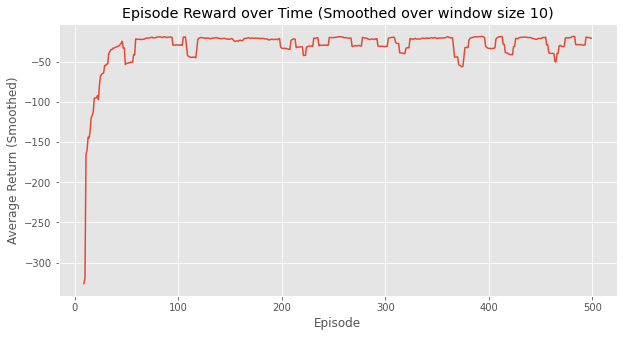

In [174]:
# episode and expected rewards plot
plot_episode_stats(stats)

In [175]:
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  0  1  1  1  1  1  1  0  1  2  2]
 [ 1  0  1  1  0  1  1  1  0  0  1  2]
 [ 0  0  0  0  0  0  1  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'up' 'right' 'right' 'right' 'right' 'right' 'right' 'up'
  'right' 'down' 'down']
 ['right' 'up' 'right' 'right' 'up' 'right' 'right' 'right' 'up' 'up'
  'right' 'down']
 ['up' 'up' 'up' 'up' 'up' 'up' 'right' 'up' 'up' 'up' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-15.75738367 -15.55632154 -14.49173364 -12.91769435 -11.25785639
  -10.18537583  -8.68089064  -7.27713827  -8.00555746  -5.56386898
   -4.26794441  -3.93490889]
 [-17.73605925 -16.90024413 -14.35679625 -13.33309079 -12.12317309
  -11.57616445 -10.49521758  -9.50925336  -7.61812932  -7.07908104
   -3.11776621  -2.54484887]
 [-17.64287625 -16.01135181 -15.09851975 -14.21251442 -13.00737322
  -11.35296582 -10.48269381  -9.91477503  -9.200

# Q3. Q-learning

In [176]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(obs):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[obs])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [177]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        for t in itertools.count():
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [178]:
Q, stats = q_learning(env, 500)

Episode 500/500.

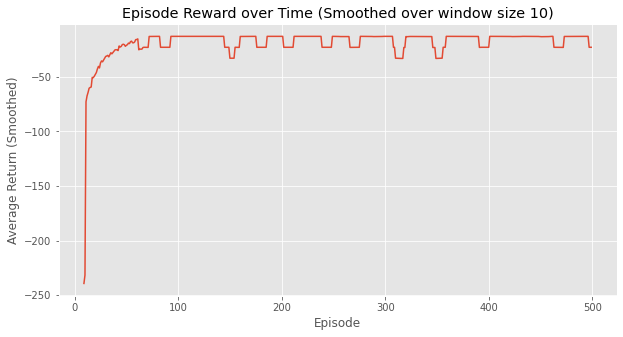

In [179]:
# episode and expected rewards plot
plot_episode_stats(stats)

In [82]:
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  2  2  1  1  1  2  1  1  2]
 [ 1  1  0  1  3  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'down' 'down' 'right' 'right' 'right' 'down'
  'right' 'right' 'down']
 ['right' 'right' 'up' 'right' 'left' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-11.1339619  -10.628736    -9.95425626  -9.1882717   -8.46938868
   -7.64126222  -6.95511374  -6.18331443  -5.3061077   -4.5489931
   -3.70860939  -2.94821961]
 [-11.36207581 -10.78245174  -9.89770311  -9.14756348  -8.31137949
   -7.51620908  -6.63177683  -5.76088237  -4.84638695  -3.942866
   -2.98186038  -1.99986803]
 [-12.         -11.         -10.          -9.          -8.
   -7.          -6. 

Word Explanation: \
$\;\;$According to the outpus above, if the starting position is the lower left, then Sarsa has the optimal policy that it will goes to the top and move to the most right and then goes down to bottom right. Q-learning will go to one step up and move to the most right and then move down to the most right. It seems that Sarsa will choose a safer path, while Q-learning will choose a more optimal but more dangerous path. According to the epoch and average rewards graphs, Q-learing converges faster than Sarsa.

# Q4

In [7]:
import numpy as np
import pandas as pd
import time
import gym
import random
import sys
import matplotlib.pyplot as plt


In [96]:
class QLearning:
    def __init__(self, learning_rate=0.1, reward_decay=0.99, e_greedy=0.9):
        self.lr = learning_rate         
        self.gamma = reward_decay       
        self.epsilon = e_greedy         
        self.num_cos = 10               
        self.num_sin = 10               
        self.num_dot = 10 
        self.num_actions = 10 
        self.actions = self.toBins(-2.0, 2.0, self.num_actions)    
        # q-table 2d
        self.q_table =  np.random.uniform(low=-1, high=1, size=(self.num_cos*self.num_sin*self.num_dot, self.num_actions))
        self.cos_bins = self.toBins(-1.0, 1.0, self.num_cos)
        self.sin_bins = self.toBins(-1.0, 1.0, self.num_sin)
        self.dot_bins = self.toBins(-8.0, 8.0, self.num_dot)

    # choose best action
    def choose_action(self,state):
        # if epsilon=0.9, 0.1 random
        if np.random.uniform() < self.epsilon:
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice(self.actions)
        action = -2 + 4/(self.num_actions-1) * action  #from discretized number to range
        return action

    # divide into intervals
    def toBins(self,clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    # < 5.5 -> 0, > 5.5 1
    def digit(self,x, bin): 
        n = np.digitize(x,bins = bin)
        return n

    # Discretization
    def digitize_state(self,observation):
        cart_sin, cart_cos , cart_dot = observation
        digitized = [self.digit(cart_sin,self.cos_bins),
                    self.digit(cart_cos,self.sin_bins),
                    self.digit(cart_dot,self.dot_bins),]
        return (digitized[1]*self.num_cos + digitized[0]) * self.num_dot + digitized[2]

    # update Q
    def learn(self, state, action, r, next_state):
        action = self.digit(action,self.actions)
        next_action = np.argmax(self.q_table[next_state]) 
        q_predict = self.q_table[state, action]
        q_target = r + self.gamma * self.q_table[next_state, next_action]  
        self.q_table[state, action] += self.lr * (q_target - q_predict)   # update

def train(num_episodes):
    env = gym.make('Pendulum-v1', g=9.81)   
    agent = QLearning()
    action = [0]    
    states = []
    for i in range(1, num_episodes+1):  
        observation = env.reset()  
        state = agent.digitize_state(observation)  #Discretization
        total_rewards = 0
        for t in range(200):   # 
            action[0] = agent.choose_action(state)  #actions from -2 to 2
            observation, reward, done, info = env.step(action)   
            next_state = agent.digitize_state(observation)
            if done:
                reward-=200  #for some actions the fail directly, penalize more
            if reward >= -1: # maximum reward is 0
                reward+=40   # when cose to 0, which is the best sutition, add more rewards
                #print('arrive')
            # print(action,reward,done,state,next_state)
            total_rewards += reward
            agent.learn(state,action[0],reward,next_state)
            state = next_state
            if done:   #done reload new env 
                break
        states.append(total_rewards)
        print("\rEpisode {}/{}.".format(i, num_episodes), end="")
        sys.stdout.flush()
        
    env.close()
    
    return agent, states

def test(agent):
    env = gym.make('Pendulum-v1', g=9.81)   
    agent.epsilon = 1 # for test, we need to make epsilon 1, since we need the potimal policy
    observation = env.reset()  
    state = agent.digitize_state(observation)  #Discretization
    action = [0]    
    for t in range(200):   # max episod: 200 each time
        action[0] = agent.choose_action(state)  
        observation, reward, done, info = env.step(action)   
        next_state = agent.digitize_state(observation)
        agent.learn(state,action[0],reward,next_state)
        state = next_state
        env.render()    
        time.sleep(0.02)
    env.close()


In [109]:
agent, states = train(500000)

Episode 500000/500000.

In [180]:
np.save('q_table.npy', agent.q_table)

In [26]:
def plot_episode_stats(states, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    #plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(states).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(rolling_window)) 
    plt.xlabel("Episode")
    plt.ylabel("Average Return (Smoothed)")
    
    return rolling_mean

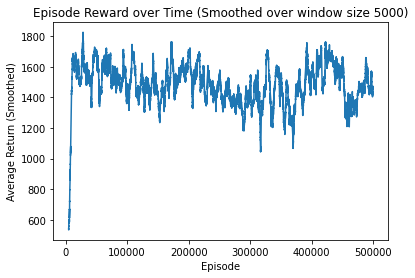

In [136]:
rolling_mean = plot_episode_stats(states, 5000)

In [184]:
# test the best agent and show the animation
test(agent)

In [ ]:
#import numpy as np
#data = np.load('q_table.npy')